# EGR 557: Dynamics II Prep

Cole Brauer

---

For my portion of the Dynamics II Prep assignment, I was given the task of acquiring and testing a sheet of rubber  material to determine its damping properties. This material will serve as one of the candidate damper materials used in our project.

## Test Setup

A 1.6 mm rubber sheet was selected as the test material. A strip of material was cut at 30 mm wide to match the target width for the final system. Two 30 mm by 75 mm links were cut from 3 mm ABS and clipped to the rubber strip to form an assembly with a flexible joint in the center. A yellow marker was placed on one end of the assembly. Finally, the mass of the side of the assembly with the marker was measured to be approximately 29.5 g.

The complete assembly was secured so that the side with the marker could swing freely. A backdrop with a grid was added behind the assembly. A camera was placed approximately 600 mm from the test setup facing directly at the test setup. The complete test setup is shown below.

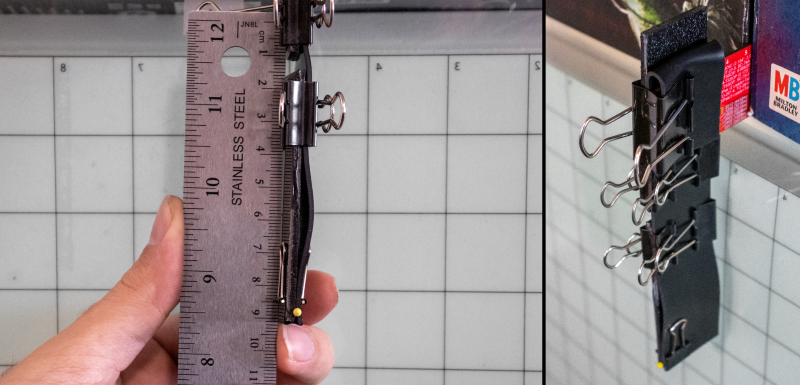

## Experiment and Data Collection

To test joint performance, the moving section of the assembly was raised to a horizontal position, then released and allowed to come to rest. The motion of the joint was captured using the camera.

The resulting videos were processed using motion tracking software. The beginning of the joint was defined as the origin, and the backdrop grid was used to set the image scale. The yellow marker was set as the target and used to track the end effector position. The figure below shows the tracker setup and results.


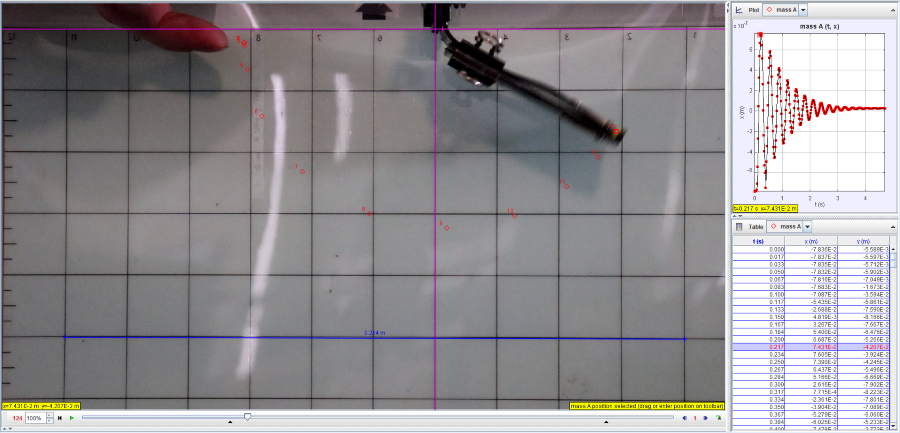

## Results

The motion tracking sofware provided a motion trajectory in the form of XY coordinates and time values. For this project, the value of interest is angular position. The XY coordinates were used to find the angular position values. All three values were then plotted over time as shown below. The trajectory of the end effector was also plotted.

In [ ]:
# Tracker data plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
from vector_tools import Vector

# Simulation
import sympy
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
from matplotlib import animation, rc
from IPython.display import HTML
plt.ion()

(-0.086086807524, 0.083769789804, -0.08685173554765, -0.0017189962593499998)

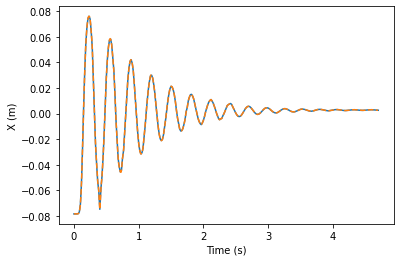

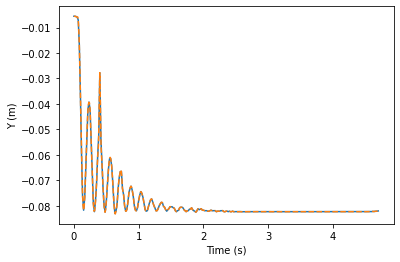

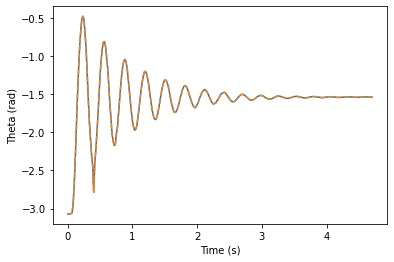

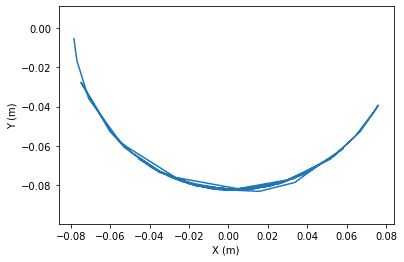

In [ ]:
df=pd.read_csv(r'MVI_9033_Track.csv', sep=',')

#x = df.x.astype('float64').to_numpy()
x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()

theta = []
base = Vector((1, 0, 0))
for i in range(len(x)):
    link = Vector((x[i], y[i], 0))
    theta.append(-link.inner_angle_2(base))
theta = np.array(theta)

xy = np.array([x,y]).T
f = si.interp1d(t,xy.T,fill_value='extrapolate',kind='quadratic')
h = si.interp1d(t,theta,fill_value='extrapolate',kind='quadratic')
new_t = np.r_[0:t[-1]:0.01]

plt.figure()
plt.plot(t,x)
plt.plot(new_t,f(new_t)[0], '--')
plt.xlabel('Time (s)')
plt.ylabel('X (m)')

plt.figure()
plt.plot(t,y)
plt.plot(new_t,f(new_t)[1], '--')
plt.xlabel('Time (s)')
plt.ylabel('Y (m)')

plt.figure()
plt.plot(t,theta)
plt.plot(new_t,h(new_t), '--')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')

plt.figure()
plt.plot(x,y)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')

## Damping Ratio

The first parameter of interest is the damping ratio of the system. To find this, the peaks of the angular position signal are first identified. The first several points are skipped so as to not include oscillations prior to release.

Text(0, 0.5, 'Theta (rad)')

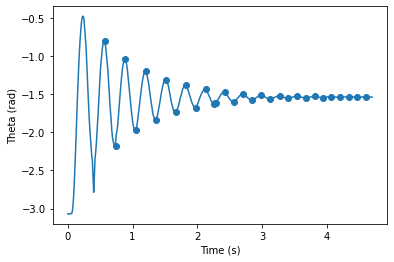

In [ ]:
sign = 1
peak_theta = []
peak_t = []
theta_p = h(0)

# Find each peak based on the sign change
for tc in new_t:
    theta_c = h(tc)
    theta_s = np.sign(theta_c - theta_p)

    if theta_s != sign:
        peak_theta.append(theta_p)
        peak_t.append(tc)
        sign = theta_s

    theta_p = theta_c

# Trim off initial points to remove release period
start_peak = 5
peak_theta = peak_theta[start_peak:]
peak_t = peak_t[start_peak:]

plt.figure()
plt.plot(new_t,h(new_t))
plt.scatter(peak_t, peak_theta)
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')

Usind these points, the damping ratio and natural frequency of the angluar motion can be found as shown below.

In [ ]:
# Logarithmic decrement
ld = np.log((peak_theta[0]-peak_theta[1])/(peak_theta[2]-peak_theta[3]))
print('Logarithmic decrement: ' + str(ld))

# Damping ratio
dr = 1/(np.sqrt(1 + ((2*np.pi)/ld)**2))
print('Damping ratio: ' + str(dr))

# Natural frequency
dnf = (2*np.pi)/(peak_t[2]-peak_t[0])
nf = dnf/(np.sqrt(1 - dr**2))
print('Natural frequency: ' + str(nf) + ' rad/s')

Logarithmic decrement: 0.38947738286732464
Damping ratio: 0.06186850230463452
Natural frequency: 19.67264078039944 rad/s


## Spring/Damper Coeffecients

To approximate the spring and damper coefficents of the system, a basic simulation was constructed, then the constants were manually tuned to achieve the best approximation of the experimental results. The code for building and plotting the simulated system is shown below.

2021-03-07 22:24:42,813 - pynamics.system - INFO - getting dynamic equations
2021-03-07 22:24:42,833 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-07 22:24:42,834 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-07 22:24:42,854 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-07 22:24:42,855 - pynamics.system - INFO - calculating function for lambdas
2021-03-07 22:24:42,923 - pynamics.integration - INFO - beginning integration
2021-03-07 22:24:42,924 - pynamics.system - INFO - integration at time 0000.00
2021-03-07 22:24:42,963 - pynamics.integration - INFO - finished integration
2021-03-07 22:24:42,980 - pynamics.output - INFO - calculating outputs
2021-03-07 22:24:42,990 - pynamics.output - INFO - done calculating outputs


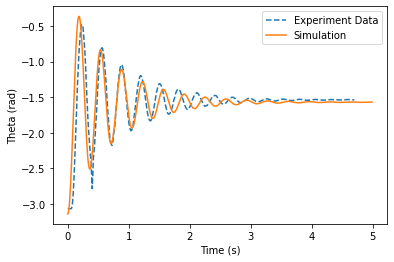

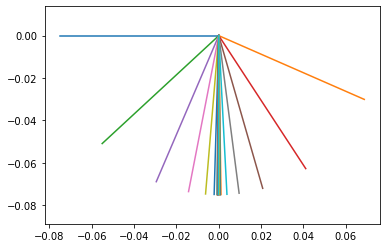

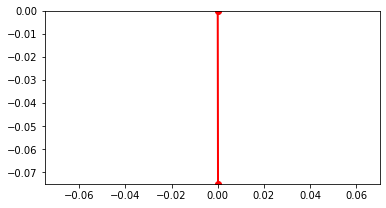

In [ ]:
# Integration tolerance
tol = 1e-4

# Time parameters
tinitial = 0
tfinal = 5
fps = 120
tstep = 1/fps
t = np.r_[tinitial:tfinal:tstep]

# System
system = System()
pynamics.set_system(__name__,system)

# System constants
length = 0.075
width = 0.030
mass = 0.0295
g = Constant(9.81,'g',system)
b = Constant(0.00015,'b',system) # joint damping
k = Constant(0.008,'k',system) # joint spring
lA = Constant(length,'lA',system) # m
mA = Constant(mass,'mA',system) # kg

# Inertia
Ixx_A = Constant((1/12)*mass*(width**2), 'Ixx_A', system)
Iyy_A = Constant((1/12)*mass*(width**2 + length**2), 'Iyy_A', system)
Izz_A = Constant((1/12)*mass*(length**2),'Izz_A',system)

# State variables
qA,qA_d,qA_dd = Differentiable('qA',system)
state_variables = system.get_state_variables()

# Initial values for state variables
initialvalues = {}
initialvalues[qA] = -np.pi
initialvalues[qA_d] = 0
ini = [initialvalues[item] for item in state_variables]

# Frames
N = Frame('N')
A = Frame('A')
system.set_newtonian(N)
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)

# Kinematics
pA = 0*N.x
pB = pA + lA*A.x

# Center of mass
pAcm = pA + (lA/2)*A.x

# Joint velocity
wA = N.getw_(A)

# Bodies
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)

# Forces
system.addforce(-b*wA, wA) # Damping
system.add_spring_force1(k, (qA + (np.pi/2))*N.z, wA)
system.addforcegravity(-g*N.y) # Gravity

# F=ma
f,ma = system.getdynamics()

# Solve for acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

# Integrate
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

# Outputs
plt.figure()
plt.plot(new_t, h(new_t), label='Experiment Data', linestyle='--')
plt.plot(t,states[:,:1], label='Simulation')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.legend()

# Motion
points = [pA, pB]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

# Animate
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

# Animate in Jupyter
HTML(points_output.anim.to_html5_video())

A comparison of the simulation and experiment results can be viewed at [youtu.be/_3vfJoK5iGE](https://youtu.be/_3vfJoK5iGE). From this simulation, the damping coeffiecent was estimated as 0.00015 and the spring constant was estimated as 0.008. These values seem to indicate that for the tested displacement angle, the rubber acts more as a spring than as a damper.

## Next Steps

These tests may need to be repeated once the final joint structure is determined. This may include changing the joint geometry or the intial joint displacement. In addition, the spring and damper coefficients could be found using an optimization package to achieve greater accuracy than the hand-tuned values. Finally, the tuned constants will be integrated into the full system simulation.

---

Cole Brauer